In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

# get data (tushare)

In [24]:
import tushare as ts

token = 'c5cba6dd1dc9c4c3578cdd046f54dfc4119fef2aabf7f998ed9a5192'
ts.set_token(token)
pro = ts.pro_api(token)

df=pro.daily(ts_code='000001.SZ', start_date='20030101',
               end_date='20190106')

df.index = pd.to_datetime(df.trade_date)
df.sort_index(ascending=True,inplace = True)  #####

df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,,
2003-01-02,000001.SZ,20030102,10.35,10.35,9.99,10.03,10.49,-0.46,-4.39,64848.85,65629.6488
2003-01-03,000001.SZ,20030103,10.00,10.10,9.91,10.02,10.03,-0.01,-0.10,49594.69,49522.8547
2003-01-06,000001.SZ,20030106,10.03,10.12,9.91,10.06,10.02,0.04,0.40,36553.07,36626.6662
2003-01-07,000001.SZ,20030107,10.06,10.15,10.01,10.04,10.06,-0.02,-0.20,27149.59,27361.4667
2003-01-08,000001.SZ,20030108,10.00,10.74,10.00,10.53,10.04,0.49,4.88,80421.70,83768.8306


In [25]:
print(df.shape)

(3735, 11)


In [36]:
def getData(df, column, train_end=-300, days_before=30, days_pred=7,return_all=True, generate_index=False):
    series = df[column].copy()
    
    #train set
    data = pd.DataFrame()
    
    #prepare days
    for i in range(days_before):
        #print(i, i - days_before - days_pred)
        data['b%d' % i] = series.tolist()[i: i - days_before - days_pred]
    
    #predict day
    for i in range(days_pred):
        data['y%d' % i] = series.tolist()[days_before + i : -days_pred+i]
        
    # is index?
    if generate_index:
        data.index = series.index[days_before:]
    
    train_data, val_data, test_data = data[:train_end-300],data[train_end-300:train_end],data[train_end:]
    
    if return_all:
        return train_data, val_data,test_data, series, df.index.tolist()
    
    return train_data, val_data, test_data

In [37]:
# test function: getData
train_data, val_data,test_data, all_series, df_index = getData(df,'high')

In [39]:
train_data.head()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,b27,b28,b29,y0,y1,y2,y3,y4,y5,y6
0,10.35,10.10,10.12,10.15,10.74,10.90,10.82,10.59,11.44,11.69,...,11.32,11.38,11.27,10.99,11.13,11.39,11.39,11.49,11.47,11.31
1,10.10,10.12,10.15,10.74,10.90,10.82,10.59,11.44,11.69,11.45,...,11.38,11.27,10.99,11.13,11.39,11.39,11.49,11.47,11.31,11.15
2,10.12,10.15,10.74,10.90,10.82,10.59,11.44,11.69,11.45,11.54,...,11.27,10.99,11.13,11.39,11.39,11.49,11.47,11.31,11.15,11.06
3,10.15,10.74,10.90,10.82,10.59,11.44,11.69,11.45,11.54,11.70,...,10.99,11.13,11.39,11.39,11.49,11.47,11.31,11.15,11.06,10.88
4,10.74,10.90,10.82,10.59,11.44,11.69,11.45,11.54,11.70,11.70,...,11.13,11.39,11.39,11.49,11.47,11.31,11.15,11.06,10.88,10.85


# LSTM

In [66]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
        input_size = 1,
        hidden_size = 128,
        num_layers= 1,
        batch_first = True)
        
        self.out = nn.Sequential(
        nn.Linear(128,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # 'None' stands for use all zeros as hidden state input
        out = self.out(r_out[:, -7:, :])                     # use the last day as output
        
        return out

# Define my_Dataset

In [52]:
class TrainSet(Dataset) :
    def __init__(self, data):
        self.data, self.label = data[:, :-7].float(), data[:, -7:].float()
        
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    
    def __len__(self):
        return len(self.data)

# hyperparameters

In [86]:
LR = 0.0001
EPOCH = 100
EARLY_STOP = True
EARLY_STOP_STEP = 20
TRAIN_END = -300
DAYS_BEFORE = 30
DAYS_PRED = 7

# Train

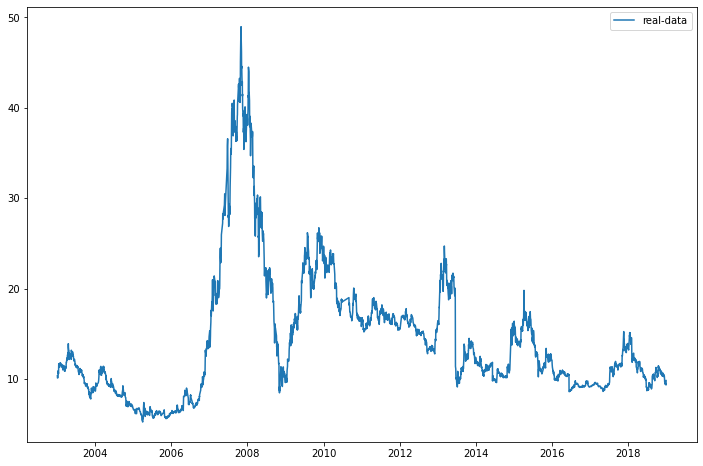

In [128]:
#GET DATA
train_data, val_data,test_data, all_series, df_index = getData(df,'high', days_before=DAYS_BEFORE, days_pred=DAYS_PRED, train_end=TRAIN_END)

#raw data
all_series_test1 = np.array(all_series.copy().tolist())

plt.figure(figsize=(12,8))
plt.plot(df_index, all_series_test1, label='real-data')
plt.legend()

## normlize

In [132]:
train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

val_data_numpy = np.array(val_data)
val_data_numpy = (val_data_numpy - train_mean) / train_std
val_data_tensor = torch.Tensor(val_data_numpy)

test_data_numpy = np.array(train_data)
test_data_numpy = (test_data_numpy - train_mean) / train_std
test_data_tensor = torch.Tensor(test_data_numpy)

## dataloader

In [134]:
train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size = 256, shuffle=True)

val_set = TrainSet(val_data_tensor)
val_loader = DataLoader(val_set,batch_size=256, shuffle=True)

In [135]:
for tx,ty in train_loader:
    print(tx.shape)
    print(ty.shape)
    break

torch.Size([256, 30])
torch.Size([256, 7])


# train model

In [138]:
rnn = LSTM()

# put model into cuda
if torch.cuda.is_available():
    rnn = rnn.cuda

############optimizer and loss function###############
optimizer = torch.optim.Adam(rnn.parameters(), lr = LR)
loss_func = nn.MSELoss()

best_loss = np.inf
##################################################

if not os.path.exists('weights'):
    os.mkdir('weights')

early_stop_now = 0    

for epoch in range(EPOCH):
    print("--"*60)
    step = 0
    # trainning
    for tx, ty in train_loader:
    
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()
            
        output = rnn(torch.unsqueeze(tx, dim = 2)) 
        loss = loss_func(torch.squeeze(output), ty)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print('epoch : %d  ' %epoch, 'step : %d' %step, 'train_loss :  %.4f' % loss.cpu().item())
            
        step += 1
    
    # validation
    with torch.no_grad():
        for tx, ty in val_loader:
            if torch.cuda.is_available():
                tx = tx.cuda()
                ty = ty.cuda()
                
            output = rnn(torch.unsqueeze(tx, dim=2))     #unsqueeze: returns a new tensor with a dimension of size one inserted at the specified position
            loss = loss_func(torch.squeeze(output), ty)  #squeeze: retures a tensor with all the dim of input of sieze 1 removed
            
            print('epoch : %d ' % epoch, 'val_loss : %.4f' % loss.cpu().item())
            
            if loss.cpu().item() < best_loss:
                early_stop_now = 0
                best_loss = loss.cpu().item()
                torch.save(rnn.state_dict(), 'weights/rnn.pkl')
                print('new model saved at epoch {} with val_loss {}'.format(epoch, best_loss))
            else:
                early_stop_now += 1
                
    if EARLY_STOP and early_stop_now > EARLY_STOP_STEP:
        print('***************warning: early stop**************')
        break
                    

------------------------------------------------------------------------------------------------------------------------
epoch : 0   step : 0 train_loss :  1.0702
epoch : 0   step : 10 train_loss :  1.0331
epoch : 0  val_loss : 0.6019
new model saved at epoch 0 with val_loss 0.6019479036331177
epoch : 0  val_loss : 0.5996
new model saved at epoch 0 with val_loss 0.5996028780937195
------------------------------------------------------------------------------------------------------------------------
epoch : 1   step : 0 train_loss :  1.1916
epoch : 1   step : 10 train_loss :  1.0271
epoch : 1  val_loss : 0.5677
new model saved at epoch 1 with val_loss 0.5677200555801392
epoch : 1  val_loss : 0.5574
new model saved at epoch 1 with val_loss 0.5574066638946533
------------------------------------------------------------------------------------------------------------------------
epoch : 2   step : 0 train_loss :  0.8442
epoch : 2   step : 10 train_loss :  0.9856
epoch : 2  val_loss : 0.52

epoch : 26   step : 0 train_loss :  0.0530
epoch : 26   step : 10 train_loss :  0.0469
epoch : 26  val_loss : 0.0042
epoch : 26  val_loss : 0.0028
------------------------------------------------------------------------------------------------------------------------
epoch : 27   step : 0 train_loss :  0.0549
epoch : 27   step : 10 train_loss :  0.0510
epoch : 27  val_loss : 0.0039
epoch : 27  val_loss : 0.0055
------------------------------------------------------------------------------------------------------------------------
epoch : 28   step : 0 train_loss :  0.0642
epoch : 28   step : 10 train_loss :  0.0399
epoch : 28  val_loss : 0.0038
epoch : 28  val_loss : 0.0030
------------------------------------------------------------------------------------------------------------------------
epoch : 29   step : 0 train_loss :  0.0506
epoch : 29   step : 10 train_loss :  0.0455
epoch : 29  val_loss : 0.0037
epoch : 29  val_loss : 0.0039
-------------------------------------------------

# load pre-trained model

rnn = LSTM()

rnn = torch.load('weights/rnn_example.pkl')

# draw some plots

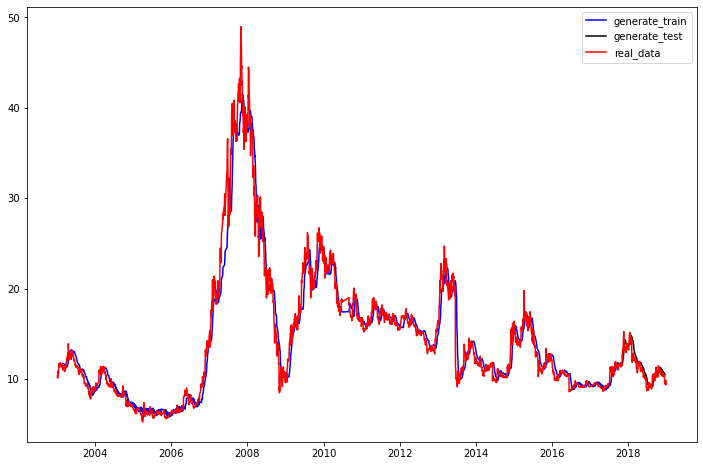

In [140]:
generate_data_train = []
generate_data_test = []

test_start = len(all_series_test1) + TRAIN_END

all_series_test1 = (all_series_test1 - train_mean) / train_std
all_series_test1 = torch.Tensor(all_series_test1)

for i in range(DAYS_BEFORE, len(all_series_test1) - DAYS_PRED, DAYS_PRED):
    x = all_series_test1[i - DAYS_BEFORE : i]
    # x -> (bs, ts, is)
    x = torch.unsqueeze(torch.unsqueeze(x,dim=0),dim=2)
    
    if torch.cuda.is_available():
        x=x.cuda()
        
    y= torch.squeeze(rnn(x))
    
    if i< test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    
generate_data_train = np.concatenate(generate_data_train, axis=0)
generate_data_test = np.concatenate(generate_data_test, axis=0)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: len(generate_data_train) + DAYS_BEFORE], generate_data_train, 'b' , label ='generate_train')
plt.plot(df_index[TRAIN_END: len(generate_data_test) + TRAIN_END], generate_data_test, 'k', label ='generate_test')
plt.plot(df_index, all_series_test1.clone().numpy() * train_std + train_mean, 'r',label ='real_data')
plt.legend()
plt.show()

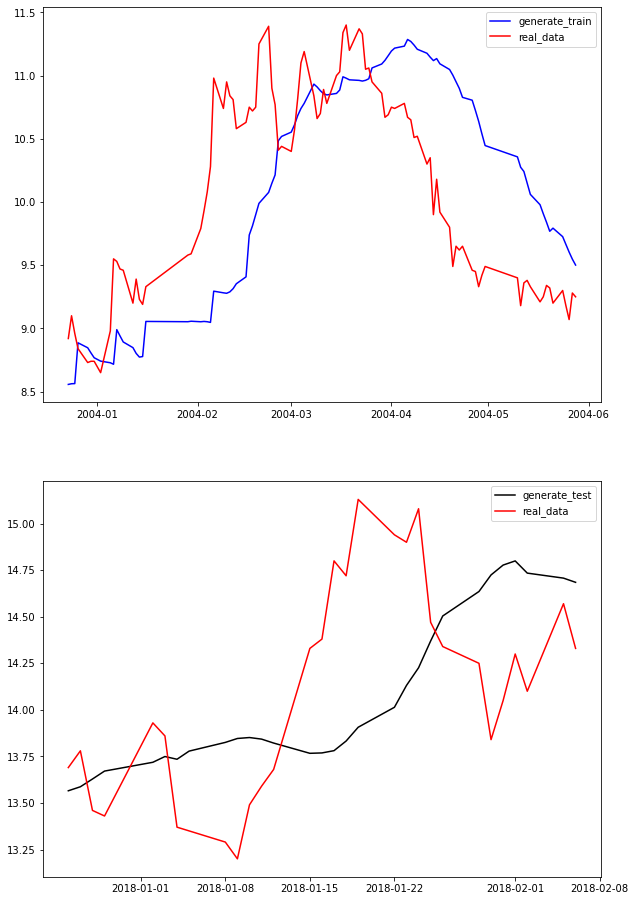

In [146]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[200+DAYS_BEFORE: 300 + DAYS_BEFORE],
         generate_data_train[200:300],'b',label='generate_train')
plt.plot(df_index[200+DAYS_BEFORE: 300 + DAYS_BEFORE],
         (all_series_test1.clone().numpy()*train_std + train_mean)[200+DAYS_BEFORE:300+DAYS_BEFORE],'r',label='real_data')

plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END+50:TRAIN_END+80], 
         generate_data_test[50:80],'k',label='generate_test')
plt.plot(df_index[TRAIN_END+50:TRAIN_END+80], 
         (all_series_test1.clone().numpy()*train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80],
        'r',label = 'real_data')

plt.legend()

plt.show()

In [112]:
train_std

7.693692695897076